In [97]:
import numpy as np
import pandas as pd

import seaborn
import matplotlib.pyplot as plt

from math import ceil
seaborn.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 3.5})

**Read election data, and replace NaNs with 0**

In [98]:
data = pd.read_csv("historical_election_results.csv", encoding='ISO-8859-1')

# Fudge because there were 2 elections in 1974, so we treat the 1st as 1974 and the 2nd as 1975
data.election.replace("1974F", "1974", inplace=True)
data.election.replace("1974O", "1975", inplace=True)


# Convert the election year into an integer, so I can select on it
election_years = pd.to_numeric(data['election'])
data['election'] = election_years

# Just want to look at (relatively) recent elections
data = data[data['election'] > 1975]

# Get rid of NaNs
data.fillna(0, inplace=True)

data.rename(columns={"lib_votes ": "lib_votes"}, inplace=True)

In [99]:
data.head()

,constituency_id,seats,constituency,country/region,electorate,con_votes,con_share,lib_votes,lib_share,lab_votes,lab_share,natSW_votes,natSW_share,oth_votes,oth_share,total_votes,turnout,election,boundary_set
10548,1,1,ABERAVON,Wales,64864,12692.0,0.247,4624,0.090,31665,0.617,1954.0,0.038,406.0,0.008,51341,0.792,1979,1974-79
10549,2,1,ABERDARE,Wales,47500,6453.0,0.173,0,0.000,26716,0.715,3652.0,0.098,518.0,0.014,37339,0.786,1979,1974-79
10550,3,1,ABERDEEN NORTH,Scotland,64747,7657.0,0.170,4887,0.108,26771,0.593,5796.0,0.128,0.0,0,45111,0.697,1979,1974-79
10551,4,1,ABERDEEN SOUTH,Scotland,65090,20820.0,0.407,5901,0.115,20048,0.392,4361.0,0.085,0.0,0,51130,0.786,1979,1974-79
10552,7,1,ABERTILLERY,Wales,35602,4613.0,0.162,0,0.000,21698,0.760,2248.0,0.079,0.0,0,28559,0.802,1979,1974-79


In [100]:
vote_columns = [col for col in data if "votes" in col and "total" not in col]
new_votes = pd.DataFrame()

for col in vote_columns:
    new_votes[col] = pd.to_numeric(data[col], errors="coerce").fillna(0.0)

data[vote_columns] = new_votes
data["won_by"] = new_votes.idxmax(axis="columns").str.replace("_votes", "").str.replace(" ", "")
data.head()

,constituency_id,seats,constituency,country/region,electorate,con_votes,con_share,lib_votes,lib_share,lab_votes,lab_share,natSW_votes,natSW_share,oth_votes,oth_share,total_votes,turnout,election,boundary_set,won_by
10548,1,1,ABERAVON,Wales,64864,12692.0,0.247,4624,0.090,31665,0.617,1954.0,0.038,406.0,0.008,51341,0.792,1979,1974-79,lab
10549,2,1,ABERDARE,Wales,47500,6453.0,0.173,0,0.000,26716,0.715,3652.0,0.098,518.0,0.014,37339,0.786,1979,1974-79,lab
10550,3,1,ABERDEEN NORTH,Scotland,64747,7657.0,0.170,4887,0.108,26771,0.593,5796.0,0.128,0.0,0,45111,0.697,1979,1974-79,lab
10551,4,1,ABERDEEN SOUTH,Scotland,65090,20820.0,0.407,5901,0.115,20048,0.392,4361.0,0.085,0.0,0,51130,0.786,1979,1974-79,con
10552,7,1,ABERTILLERY,Wales,35602,4613.0,0.162,0,0.000,21698,0.760,2248.0,0.079,0.0,0,28559,0.802,1979,1974-79,lab


Election in year 1979 was won by con with 337 seats and a majority of 43
Total vote changes needed to remove government majority = 9493

Election in year 1983 was won by con with 395 seats and a majority of 145
Total vote changes needed to remove government majority = 121906

Election in year 1987 was won by con with 374 seats and a majority of 103
Total vote changes needed to remove government majority = 67654

Election in year 1992 was won by con with 334 seats and a majority of 21
Total vote changes needed to remove government majority = 1998

Election in year 1997 was won by lab with 416 seats and a majority of 179
Total vote changes needed to remove government majority = 188370

Election in year 2001 was won by lab with 410 seats and a majority of 169
Total vote changes needed to remove government majority = 156675

Election in year 2005 was won by lab with 353 seats and a majority of 69
Total vote changes needed to remove government majority = 20481

Election in year 2010 was won

DataError: No numeric types to aggregate

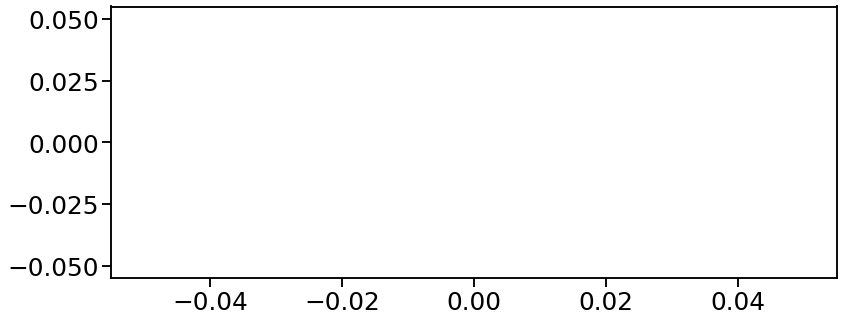

In [101]:
election_data = {}
seat_margins = []
majorities = []


# First pass -- determine overall winner and 2nd place parties in election
for index, row in enumerate(data.itertuples()):
    if row.election not in election_data:
        election_data[row.election] = {
            "lab": 0,
            "con": 0,
            "lib": 0,
            "natSW": 0,
            "oth": 0,
        }
    
    election_data[row.election][row.won_by] += 1

    
# Correct for 10 DUP MPs in coalition with Tories in 2017
election_data[2017]['con'] += 10
election_data[2017]['oth'] -= 10

# Correct for Sinn Fein MPs, who do not take their seats
# https://en.wikipedia.org/wiki/List_of_Sinn_F%C3%A9in_MPs
election_data[1979]['oth'] -= 0
election_data[1983]['oth'] -= 1
election_data[1987]['oth'] -= 1
election_data[1992]['oth'] -= 0
election_data[1997]['oth'] -= 2
election_data[2001]['oth'] -= 4
election_data[2005]['oth'] -= 5
election_data[2010]['oth'] -= 5
election_data[2015]['oth'] -= 4
election_data[2017]['oth'] -= 7
election_data[2019]['oth'] -= 7

# Correct for speaker and deputies -- 2 MPs from Labour and Cons
for election in election_data:
    election_data[election]['lab'] -= 2
    election_data[election]['con'] -= 2


# For 2010, add LD seats to CONs, as they went into coalition
election_data[2010]['con'] += election_data[2010]['lib']
election_data[2010]['lib'] = 0


swing_votes_by_election = []

for election in data.election.unique():
    winning_party, winning_seats = sorted(election_data[election].items(), key=lambda x: x[1])[-1]
    second_party, second_seats = sorted(election_data[election].items(), key=lambda x: x[1])[-2]
    vote_changes_by_seat = []
    
    for index, row in enumerate(data[data["election"] == election].itertuples()):
        votes = [
            ("lab", row.lab_votes),
            ("con", row.con_votes),
            ("lib", row.lib_votes),
            ("natSW", row.natSW_votes),
            ("oth", row.oth_votes),
        ]

        sorted_votes = sorted(votes, key=lambda x: x[1])
 
        # If 2nd placed party is the party that came 2nd overall, then keep track of this value and the sea
        # so we can then sort the seats by num vote-changes needed for 2nd placed party to win.
        
        if sorted_votes[-2][0] == second_party and sorted_votes[-1][0] == winning_party:
            vote_changes_needed = ceil( (sorted_votes[-1][1] - sorted_votes[-2][1]) / 2.0 )
            vote_changes_by_seat.append( (row.constituency, vote_changes_needed) )
        
        vote_changes_by_seat.sort(key=lambda x: x[1])
    
    
    seats = election_data[election]
    winning_party_seats = max(seats.values())
    second_party_seats = sorted(seats.values())[-2]
    total_seats = sum(seats.values())
    seats_won_by_other_parties = total_seats - winning_party_seats
    majority = winning_party_seats - seats_won_by_other_parties
    majorities.append((year, majority))
    
    print(f"Election in year {election} was won by {winning_party} with {winning_seats} seats and a majority of {majority}")
        
    num_seat_gains_needed_to_remove_majority = ceil(majority / 2) + 1
    marginal_seat_changes_needed = vote_changes_by_seat[0: num_seat_gains_needed_to_remove_majority]

    if election == 2017:
        print(f"The top {len(marginal_seat_changes_needed)} most marginal (Con / Lab) seats were")
        print(marginal_seat_changes_needed)
    
    total_swing_votes_for_hung_parliament = sum([x[1] for x in marginal_seat_changes_needed])
    
    swing_votes_by_election.append((
        election, 
        total_swing_votes_for_hung_parliament, 
        winning_party, 
        second_party, 
        num_seat_gains_needed_to_remove_majority
    ))
    
    print(f"Total vote changes needed to remove government majority = {total_swing_votes_for_hung_parliament}")
    print("")
    
    #print(f"year = {year}, seats = {seats}, 2nd #seats = {second_party_seats}")
    #print(f"total_seats = {total_seats}, majority = {majority}, num seat changes = {num_seat_gains_needed_to_remove_majority}")


swing_votes = pd.DataFrame({
    "Year": [x[0] for x in swing_votes_by_election], 
    "Seats": [x[4] for x in swing_votes_by_election], 
    "Votes": [f"{x[1]:,}" for x in swing_votes_by_election],
    "Winner": [x[2] for x in swing_votes_by_election],
    "Second": [x[3] for x in swing_votes_by_election],
})


print("Year,Winner,2nd,Seats,Votes")
for row in swing_votes.itertuples():
    print(f"{row.Year}\t{row.Winner}\t{row.Second}\t{row.Seats}\t{row.Votes}")

print(swing_votes)

plt.rcParams['figure.figsize'] = [13, 5]
chart = seaborn.lineplot(x="Year", y="Votes", data=swing_votes, marker='o')
plt.title("Vote changes needed to remove government majority in UK general elections since 1979");

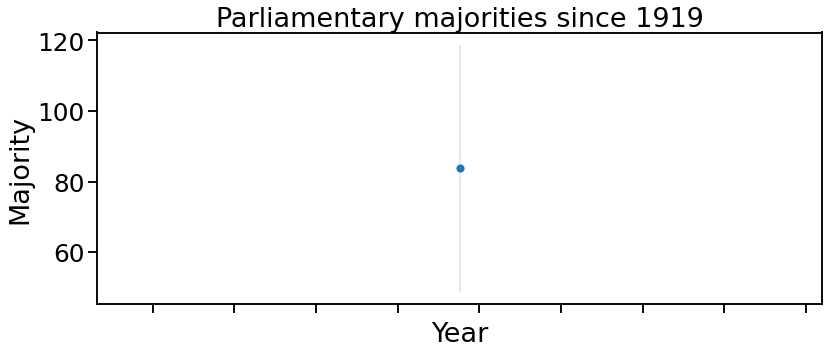

In [95]:
data = pd.DataFrame({
    "Year": [x[0] for x in majorities], 
    "Majority": [x[1] for x in majorities]
})

plt.rcParams['figure.figsize'] = [13, 5]
chart = seaborn.lineplot(x="Year", y="Majority", data=data, marker='o')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=360, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'

)
plt.title("Parliamentary majorities since 1919");